In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv('HR_Analytics.csv', encoding='utf-8')

df.info()

# 전처리
# 데이터프레임에서 필요한 열만 선택하고 결측값 삭제
df = df.drop(['EmpID', 'AgeGroup', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
print(df.head())
# 결측값이 있는 'YearsWithCurrManager' 열을 기준으로 행 삭제
df.dropna(subset=['YearsWithCurrManager'], inplace=True)

# 특성과 타겟 변수 분리
X = df.drop('Attrition', axis=1)
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# 변수 구분
numerical_features = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                      'NumCompaniesWorked', 'PercentSalaryHike', 
                      'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
                      'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
ordinal_features = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction',
                    'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'JobLevel']
nominal_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'SalarySlab', 'MaritalStatus', 'OverTime']

# 스케일링 및 인코딩 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # 연속형 변수는 표준화
        ('ord', OrdinalEncoder(), ordinal_features),    # 순서형 변수는 순서형 인코딩
        ('nom', OneHotEncoder(drop='first', sparse_output=False), nominal_features)  # 명목형 변수는 원-핫 인코딩
    ],
    remainder='drop'  # 나머지 피처는 제외
)

# 데이터 변환
X_preprocessed = preprocessor.fit_transform(X)

# 변환된 열 이름 추출
preprocessed_feature_names = preprocessor.get_feature_names_out()

# 변환된 데이터 프레임으로 변환
X_encoded = pd.DataFrame(X_preprocessed, columns=preprocessed_feature_names)

# 결과 확인
print(X_encoded.head())
print(f"y head {y.head()}")
print(f"Shape of X_encoded: {X_encoded.shape}")
print(f"Number of columns in X_encoded: {len(X_encoded.columns)}")
print(f"Number of columns in preprocessed_feature_names: {len(preprocessed_feature_names)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1480 non-null   int64  
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1480 non-null   object 
 14  HourlyRa

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer

# 랜덤 시드 설정
random_seed = 1

# 데이터 전처리 및 모델 학습
results = {}

# 데이터 전처리 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder())
        ]), ordinal_features),
        ('nom', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # `sparse_output=False`로 설정
        ]), nominal_features)
    ],
    remainder='drop'
)

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)




# 훈련 세트와 테스트 세트에 전처리 적용 (DataFrame 유지)
X_train_df = pd.DataFrame(preprocessor.fit_transform(X_train))
X_valid_df = pd.DataFrame(preprocessor.transform(X_val))
X_test_df = pd.DataFrame(preprocessor.transform(X_test))

# 훈련 세트와 검증 세트, 테스트 세트에 전처리 적용
X_train_np = preprocessor.fit_transform(X_train)
X_valid_np = preprocessor.transform(X_val)
X_test_np = preprocessor.transform(X_test)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# 모델 리스트
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    'Neural Network': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(random_state=42))
    ]),
    'BalancedRandomForest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', BalancedRandomForestClassifier(random_state=42))
    ]),
    'EasyEnsembleClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', EasyEnsembleClassifier(random_state=42))
    ])
}


# 모델 학습 및 평가
for model_name, model_pipeline in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # 모델 학습
    model_pipeline.fit(X_train, y_train)
    
    # 예측
    y_pred_train = model_pipeline.predict(X_train)
    y_pred_val = model_pipeline.predict(X_val)
    y_pred_test = model_pipeline.predict(X_test)
    
    # 성능 평가
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # 결과 저장
    results[model_name] = {
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Classification Report': classification_report(y_test, y_pred_test)
    }

# 결과 출력
for model_name, metrics in results.items():
    print(f"\n{model_name} Performance:")
    print(f"Train Accuracy: {metrics['Train Accuracy']:.4f}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print("Classification Report:")
    print(metrics['Classification Report'])

Training and evaluating Logistic Regression...
Training and evaluating Random Forest...
Training and evaluating Neural Network...


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to

Training and evaluating BalancedRandomForest...
Training and evaluating EasyEnsembleClassifier...

Logistic Regression Performance:
Train Accuracy: 0.7934
Validation Accuracy: 0.7719
Test Accuracy: 0.7719
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       239
           1       0.40      0.78      0.53        46

    accuracy                           0.77       285
   macro avg       0.67      0.78      0.69       285
weighted avg       0.86      0.77      0.80       285


Random Forest Performance:
Train Accuracy: 1.0000
Validation Accuracy: 0.8465
Test Accuracy: 0.8526
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       239
           1       0.75      0.13      0.22        46

    accuracy                           0.85       285
   macro avg       0.80      0.56      0.57       285
weighted avg       0.84      0.85      0.81      

In [25]:
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트의 하이퍼파라미터 튜닝
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid, 
                           cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
print("Best parameters found for Random Forest:")
print(grid_search.best_params_)
print(f"Best validation accuracy: {grid_search.best_score_:.4f}")

# 최적 모델을 사용하여 테스트 세트 평가
best_rf_model = grid_search.best_estimator_
y_pred_test_rf = best_rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_test_rf))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found for Random Forest:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best validation accuracy: 0.8561
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       239
           1       0.70      0.15      0.25        46

    accuracy                           0.85       285
   macro avg       0.78      0.57      0.58       285
weighted avg       0.83      0.85      0.81       285



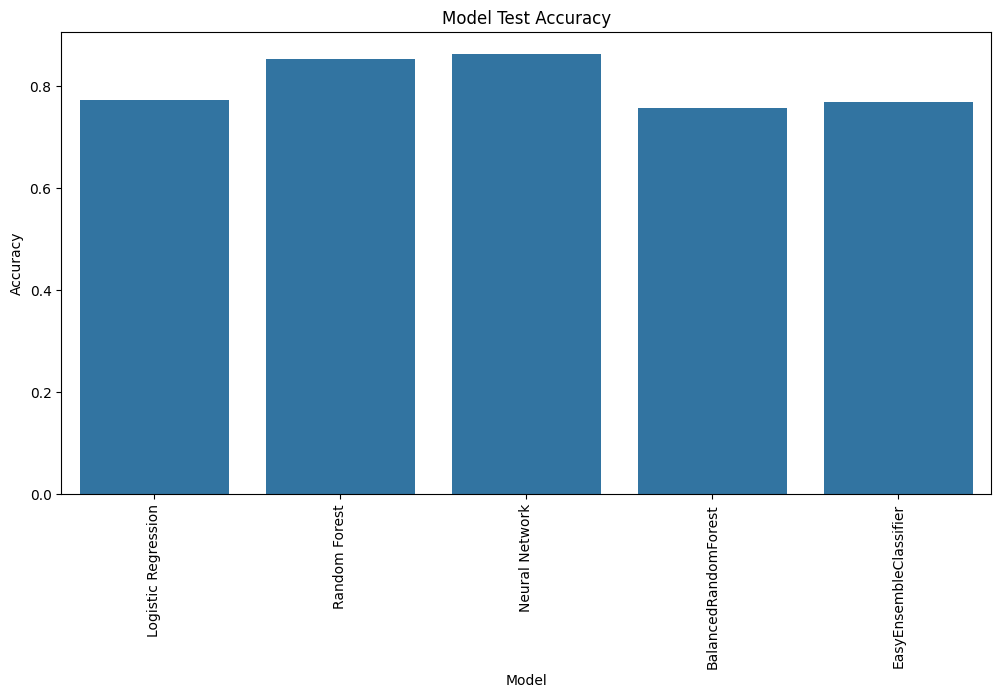

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 성능 데이터프레임 생성
results_df = pd.DataFrame(results).T

# 성능 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df['Test Accuracy'])
plt.xticks(rotation=90)
plt.title('Model Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found for MLPClassifier:
{'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}
Best validation accuracy: 0.8769
MLPClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       239
           1       0.82      0.30      0.44        46

    accuracy                           0.88       285
   macro avg       0.85      0.65      0.69       285
weighted avg       0.87      0.88      0.85       285



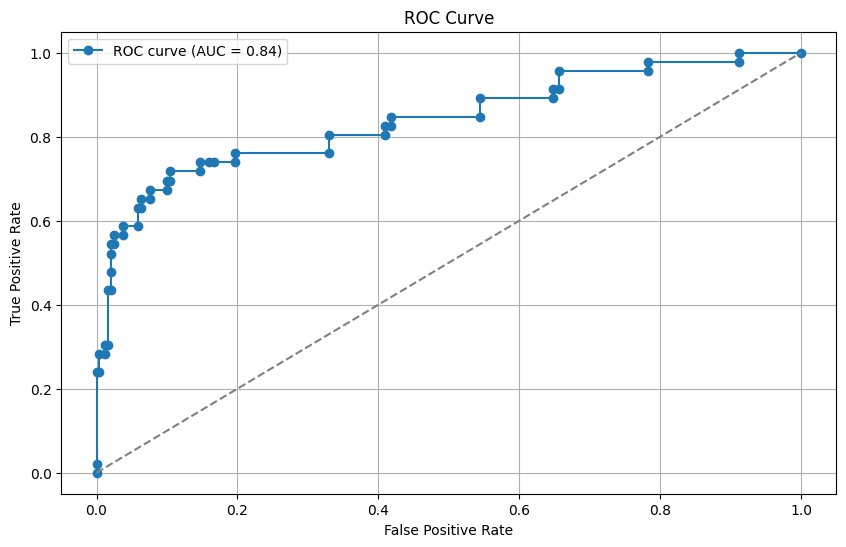

<Figure size 800x600 with 0 Axes>

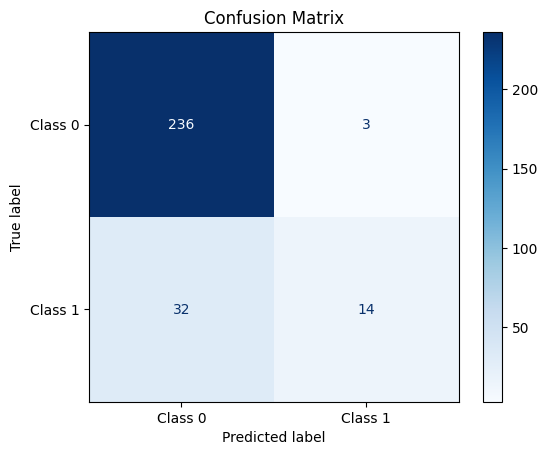

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# MLPClassifier의 하이퍼파라미터 튜닝 범위 정의
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

# MLPClassifier 모델 생성
mlp = MLPClassifier(max_iter=1000, random_state=42)

# 전체 파이프라인 구성 (여기서는 preprocessor를 가정합니다)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
print("Best parameters found for MLPClassifier:")
print(grid_search.best_params_)
print(f"Best validation accuracy: {grid_search.best_score_:.4f}")

# 최적 모델을 사용하여 테스트 세트 평가
best_mlp_model = grid_search.best_estimator_
y_pred_test_mlp = best_mlp_model.predict(X_test)
print("MLPClassifier Classification Report:")
print(classification_report(y_test, y_pred_test_mlp))

# ROC 커브와 AUC
y_prob = best_mlp_model.predict_proba(X_test)[:, 1]  # 양성 클래스의 확률
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 혼동 행렬
y_pred_test_mlp = best_mlp_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test_mlp)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Epoch 1/150


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6558 - loss: 0.6660 - val_accuracy: 0.8377 - val_loss: 0.4885
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7719 - loss: 0.5560 - val_accuracy: 0.8377 - val_loss: 0.4755
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8150 - loss: 0.4766 - val_accuracy: 0.8377 - val_loss: 0.4424
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8286 - loss: 0.5361 - val_accuracy: 0.8377 - val_loss: 0.4753
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8349 - loss: 0.4638 - val_accuracy: 0.8377 - val_loss: 0.4359
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.4190 - val_accuracy: 0.8377 - val_loss: 0.4400
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8043 - loss: 0.5107 - val_accuracy: 0.8377 - val_loss: 0.4355
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8347 - loss: 0.4150 - val_accuracy: 0.8377 - val_loss: 0.

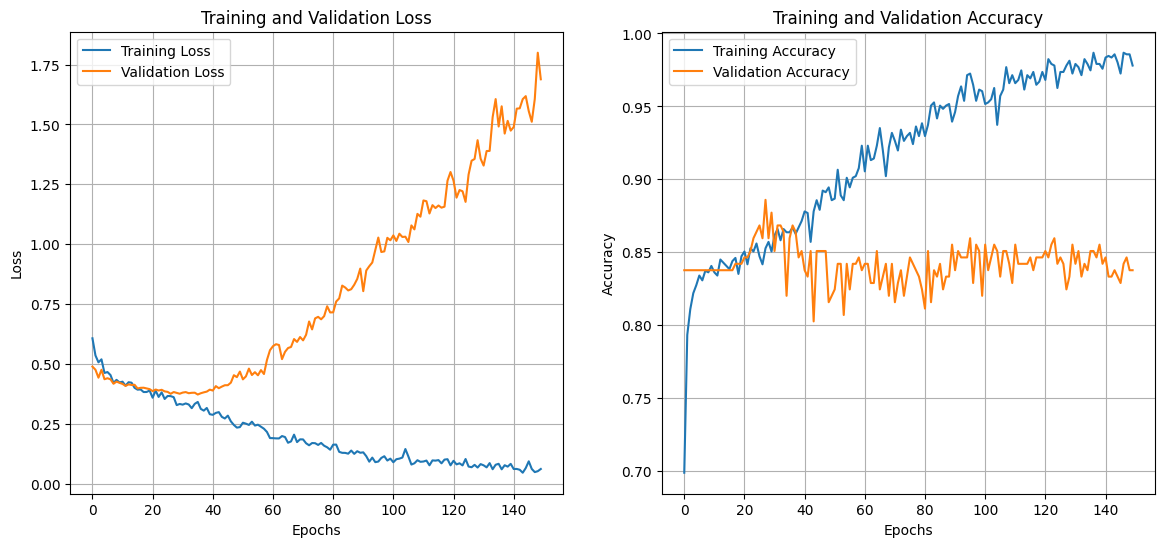

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Deep Learning Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       239
           1       0.62      0.35      0.44        46

    accuracy                           0.86       285
   macro avg       0.75      0.65      0.68       285
weighted avg       0.84      0.86      0.84       285



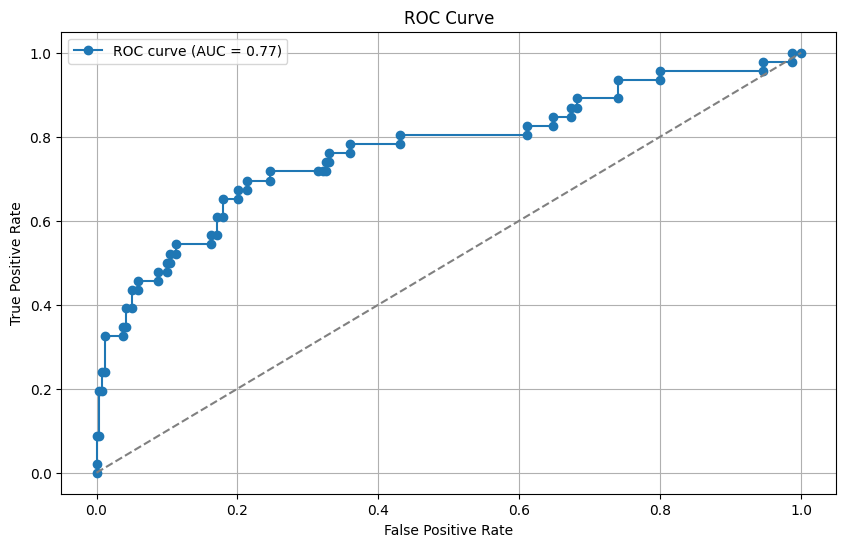

<Figure size 800x600 with 0 Axes>

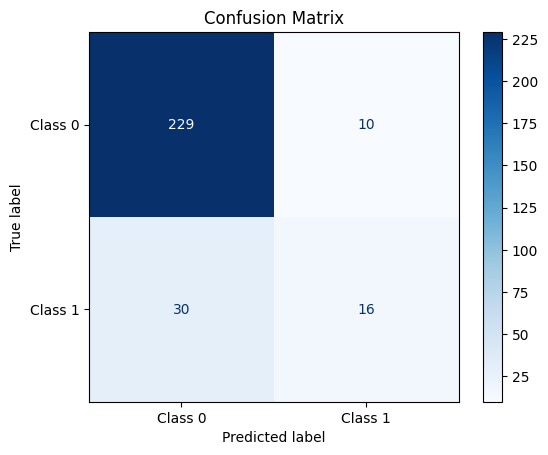

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 데이터 변환
X_train_df = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_valid_df = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

# 신경망 모델 정의
def create_model(input_dim):
    model = Sequential()
    # 첫 번째 은닉층
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    # 두 번째 은닉층
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # 세 번째 은닉층
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    # 네 번째 은닉층
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    # 출력층
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 시그모이드 출력층
    return model

# 모델 생성 및 컴파일
model = create_model(input_dim=X_train_df.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습 및 검증 손실과 정확도 시각화
def plot_training_history(history):
    # 학습 손실과 검증 손실
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # 학습 정확도와 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# 모델 학습
history = model.fit(X_train_df, y_train, validation_data=(X_valid_df, y_val), epochs=150, batch_size=32, verbose=1)

# 학습 및 검증 손실, 정확도 그래프 출력
plot_training_history(history)

# 테스트 세트 평가
y_pred_prob = model.predict(X_test_df).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)


# 분류 보고서 출력
print("Deep Learning Classification Report:")
print(classification_report(y_test, y_pred))

# ROC 커브와 AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Trial 254 Complete [00h 00m 15s]
val_accuracy: 0.8771929740905762

Best val_accuracy So Far: 0.890350878238678
Total elapsed time: 00h 40m 20s
Best hyperparameters: {'units1': 224, 'activation1': 'sigmoid', 'dropout1': 0.2, 'units2': 256, 'dropout2': 0.2, 'units3': 64, 'dropout3': 0.6000000000000001, 'units4': 16, 'dropout4': 0.5, 'optimizer': 'adam', 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0228'}


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8437 - loss: 0.3802 - val_accuracy: 0.8684 - val_loss: 0.3429 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8575 - loss: 0.3469 - val_accuracy: 0.8421 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8309 - loss: 0.4202 - val_accuracy: 0.8509 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8746 - loss: 0.3402 - val_accuracy: 0.8640 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8761 - loss: 0.3273 - val_accuracy: 0.8465 - val_loss: 0.3420 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8352 - loss: 0.3727 - val_accuracy: 0.8377 - val_loss: 0.3365 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8856 - loss: 0.3139 - val_accuracy: 0.85

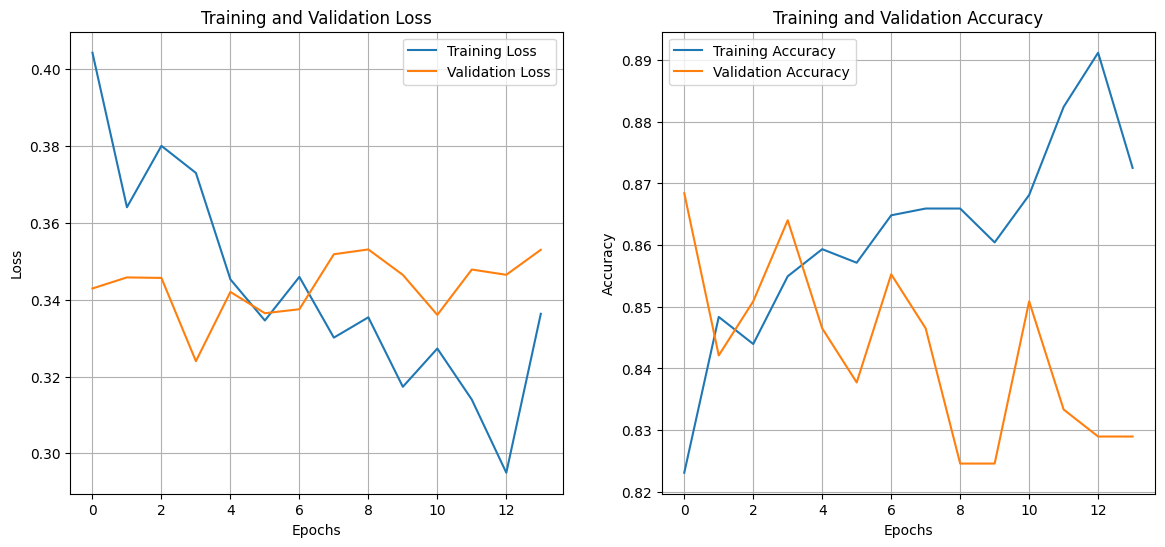

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Deep Learning Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       239
           1       0.74      0.43      0.55        46

    accuracy                           0.88       285
   macro avg       0.82      0.70      0.74       285
weighted avg       0.87      0.88      0.87       285



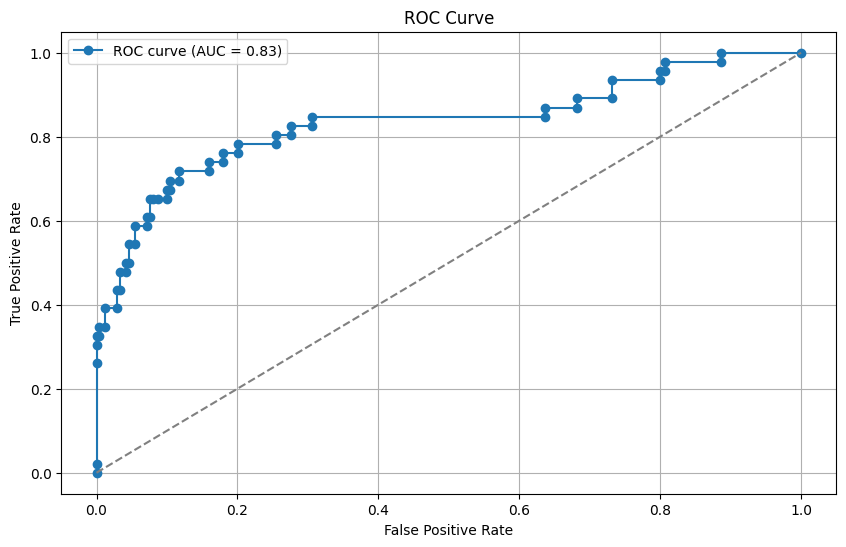

<Figure size 800x600 with 0 Axes>

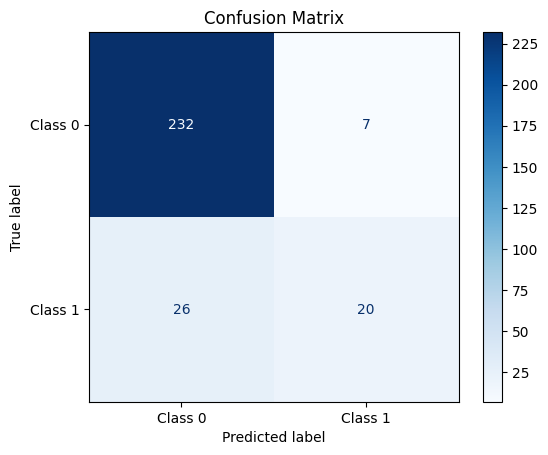

In [54]:
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import keras_tuner as kt

# 신경망 모델 정의
def create_model(hp):
    model = Sequential()
    
    # 첫 번째 은닉층
    model.add(Dense(
        hp.Int('units1', min_value=32, max_value=512, step=16), 
        input_dim=X_train_df.shape[1], 
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.7, step=0.05)))
    
    # 두 번째 은닉층
    model.add(Dense(
        hp.Int('units2', min_value=16, max_value=256, step=8), 
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.7, step=0.05)))
    
    # 세 번째 은닉층
    model.add(Dense(
        hp.Int('units3', min_value=8, max_value=128, step=4), 
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.7, step=0.05)))
    
    # 네 번째 은닉층
    model.add(Dense(
        hp.Int('units4', min_value=4, max_value=64, step=2), 
        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout4', 0.2, 0.7, step=0.05)))
    
    # 출력층
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),  # 최적화 알고리즘 추가
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 하이퍼파라미터 튜너 설정
def build_model(hp):
    return create_model(hp)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='kt_dir',
    project_name='hr_analytics'
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 하이퍼파라미터 튜닝
tuner.search(
    X_train_df, y_train,
    validation_data=(X_valid_df, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# 최적의 하이퍼파라미터 조합 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# 최적의 모델 가져오기
best_model = tuner.get_best_models(num_models=1)[0]

# 모델 학습
history = best_model.fit(
    X_train_df, y_train,
    validation_data=(X_valid_df, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# 학습 및 검증 손실, 정확도 그래프 출력
def plot_training_history(history):
    # 학습 손실과 검증 손실
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # 학습 정확도와 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_training_history(history)

# 테스트 세트 평가
y_pred_prob = best_model.predict(X_test_df).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# 분류 보고서 출력
print("Deep Learning Classification Report:")
print(classification_report(y_test, y_pred))

# ROC 커브와 AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 977us/step


  1%|          | 1/100 [00:09<15:56,  9.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 971us/step


  2%|▏         | 2/100 [00:19<15:39,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 999us/step


  3%|▎         | 3/100 [00:29<15:54,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  4%|▍         | 4/100 [00:40<16:46, 10.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


  5%|▌         | 5/100 [00:51<16:53, 10.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  6%|▌         | 6/100 [01:03<17:03, 10.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


  7%|▋         | 7/100 [01:13<16:40, 10.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


  8%|▊         | 8/100 [01:28<18:20, 11.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


  9%|▉         | 9/100 [01:43<19:33, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 10%|█         | 10/100 [02:00<21:35, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 11%|█         | 11/100 [02:24<25:22, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 12%|█▏        | 12/100 [02:50<29:25, 20.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 13%|█▎        | 13/100 [03:16<31:39, 21.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 14%|█▍        | 14/100 [03:40<31:55, 22.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 15%|█▌        | 15/100 [03:54<28:02, 19.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 16%|█▌        | 16/100 [04:07<24:58, 17.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 17%|█▋        | 17/100 [04:21<23:10, 16.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 18%|█▊        | 18/100 [04:40<23:51, 17.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 19%|█▉        | 19/100 [04:56<22:54, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 20%|██        | 20/100 [05:16<23:39, 17.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 21%|██        | 21/100 [05:45<27:47, 21.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 22%|██▏       | 22/100 [06:07<27:52, 21.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 23%|██▎       | 23/100 [06:18<23:34, 18.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 24%|██▍       | 24/100 [06:28<20:09, 15.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 25%|██▌       | 25/100 [06:39<18:07, 14.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 26%|██▌       | 26/100 [06:54<17:47, 14.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 27%|██▋       | 27/100 [07:12<19:06, 15.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 28%|██▊       | 28/100 [07:29<19:00, 15.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 29%|██▉       | 29/100 [07:45<18:53, 15.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 30%|███       | 30/100 [08:05<20:04, 17.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 31%|███       | 31/100 [08:25<20:55, 18.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 32%|███▏      | 32/100 [08:40<19:20, 17.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 33%|███▎      | 33/100 [08:51<17:08, 15.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 34%|███▍      | 34/100 [09:02<15:24, 14.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 35%|███▌      | 35/100 [09:13<14:13, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 36%|███▌      | 36/100 [09:23<13:01, 12.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 37%|███▋      | 37/100 [09:34<12:29, 11.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 38%|███▊      | 38/100 [09:47<12:32, 12.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 39%|███▉      | 39/100 [10:00<12:39, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 40%|████      | 40/100 [10:29<17:24, 17.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 41%|████      | 41/100 [10:51<18:29, 18.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 42%|████▏     | 42/100 [11:15<19:38, 20.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 43%|████▎     | 43/100 [11:30<17:38, 18.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 44%|████▍     | 44/100 [11:43<15:53, 17.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 45%|████▌     | 45/100 [11:59<15:14, 16.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 46%|████▌     | 46/100 [12:14<14:41, 16.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 47%|████▋     | 47/100 [12:30<14:18, 16.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 48%|████▊     | 48/100 [12:46<13:59, 16.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 49%|████▉     | 49/100 [13:08<15:12, 17.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6694/6694 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 50%|█████     | 50/100 [13:29<15:36, 18.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 51%|█████     | 51/100 [13:44<14:26, 17.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 52%|█████▏    | 52/100 [13:56<12:44, 15.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 53%|█████▎    | 53/100 [14:07<11:20, 14.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 54%|█████▍    | 54/100 [14:18<10:11, 13.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 55%|█████▌    | 55/100 [14:28<09:18, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 56%|█████▌    | 56/100 [14:41<09:10, 12.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 57%|█████▋    | 57/100 [14:54<09:01, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 58%|█████▊    | 58/100 [15:08<09:06, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 59%|█████▉    | 59/100 [15:24<09:36, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


 60%|██████    | 60/100 [16:00<13:48, 20.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 61%|██████    | 61/100 [16:13<11:59, 18.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 62%|██████▏   | 62/100 [16:25<10:19, 16.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 63%|██████▎   | 63/100 [16:35<08:52, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 64%|██████▍   | 64/100 [16:45<07:55, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 65%|██████▌   | 65/100 [16:56<07:16, 12.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 66%|██████▌   | 66/100 [17:07<06:45, 11.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 67%|██████▋   | 67/100 [17:18<06:27, 11.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 68%|██████▊   | 68/100 [17:34<06:54, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 69%|██████▉   | 69/100 [17:53<07:42, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 70%|███████   | 70/100 [18:10<07:48, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 71%|███████   | 71/100 [18:36<09:03, 18.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 72%|███████▏  | 72/100 [18:53<08:24, 18.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 73%|███████▎  | 73/100 [19:05<07:21, 16.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 74%|███████▍  | 74/100 [19:17<06:28, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 75%|███████▌  | 75/100 [19:29<05:53, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 76%|███████▌  | 76/100 [19:44<05:42, 14.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 77%|███████▋  | 77/100 [19:57<05:21, 13.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 78%|███████▊  | 78/100 [20:09<04:55, 13.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 79%|███████▉  | 79/100 [20:23<04:45, 13.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


 80%|████████  | 80/100 [21:06<07:30, 22.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 81%|████████  | 81/100 [21:31<07:19, 23.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 82%|████████▏ | 82/100 [21:53<06:51, 22.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 83%|████████▎ | 83/100 [22:06<05:34, 19.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 84%|████████▍ | 84/100 [22:18<04:42, 17.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 85%|████████▌ | 85/100 [22:32<04:08, 16.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 86%|████████▌ | 86/100 [22:46<03:41, 15.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 87%|████████▋ | 87/100 [23:05<03:35, 16.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step


 88%|████████▊ | 88/100 [23:40<04:26, 22.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 89%|████████▉ | 89/100 [24:07<04:18, 23.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 90%|█████████ | 90/100 [24:34<04:07, 24.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 91%|█████████ | 91/100 [24:48<03:12, 21.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 92%|█████████▏| 92/100 [24:59<02:26, 18.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 93%|█████████▎| 93/100 [25:10<01:51, 15.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 987us/step


 94%|█████████▍| 94/100 [25:20<01:25, 14.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 95%|█████████▌| 95/100 [25:30<01:04, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 96%|█████████▌| 96/100 [25:40<00:48, 12.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 97%|█████████▋| 97/100 [25:51<00:35, 11.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 98%|█████████▊| 98/100 [26:02<00:23, 11.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 99%|█████████▉| 99/100 [26:14<00:11, 11.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6688/6688 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


100%|██████████| 100/100 [26:26<00:00, 15.86s/it]


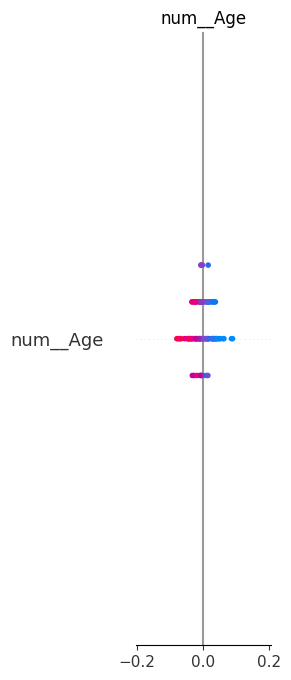

ValueError: Could not find feature named: feature_name

In [56]:
import shap

# 샘플링된 데이터로 SHAP 값 계산
sample_size = 100
X_train_sample = X_train_df.sample(sample_size)
X_test_sample = X_test_df.sample(sample_size)

# SHAP explainer 초기화
explainer = shap.KernelExplainer(best_model.predict, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)

# Summary plot
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_df.columns)

# Dependence plot
shap.dependence_plot('feature_name', shap_values, X_test_sample, feature_names=X_test_df.columns)

# Force plot (예를 들어, 첫 번째 샘플)
shap.force_plot(explainer.expected_value, shap_values[0][0], X_test_sample.iloc[0], feature_names=X_test_df.columns)